# Mouse snRNA Integrative Analysis
## Adrenal
### Data
- [Adrenal data table](https://github.com/erebboah/ENC4_Mouse_SingleCell/blob/master/snrna/ref/adrenal_minimal_metadata.tsv)

### Aims
[integrate_parse_10x.R](https://github.com/erebboah/ENC4_Mouse_SingleCell/blob/master/snrna/scripts/integrate_parse_10x.R):
1. Read in pre-processed Parse and 10x data and merge counts matrices across experiments (within the same technology) for each tissue.
2. Filter nuclei by # genes, # UMIs, percent mitochondrial gene expression, and doublet score. See [detailed metadata](https://github.com/erebboah/ENC4_Mouse_SingleCell/blob/master/snrna/ref/enc4_mouse_snrna_metadata.tsv) for filter cutoffs. The adrenal gland filters are the same as the brain filters.
3. Run SCT on the 3 objects to regress `percent.mt` and `nFeature_RNA`. Use  `method = "glmGamPoi"` to speed up this step, and save pre-integrated data in `seurat` folder.
4. Combine Parse standard, Parse deep, and 10x data by CCA integration. Use Parse standard as reference dataset because it contains all timepoints, while 10x data only contains 2 timepoints. 
5. Score nuclei by cell cycle using these [mouse cell cycle genes](https://github.com/erebboah/ENC4_Mouse_SingleCell/blob/master/snrna/ref/mouse_cellcycle_genes.rda) to aid in manual celltype annotation.

**In this notebook**:
Manual celltype annotation. Find marker genes for `gen_celltype`, `celltypes`, and `subtypes` and save in `seurat/markers`.


### Results 
- For adrenal gland, `gen_celltype` and `celltypes` are basically the same, such as "Cortex" and "Medulla" (with the exception of "Myeloid" vs. "Macrophages" and "Myonuclei" vs. "Skeletal_muscle")
- `subtypes` breaks down the cortical cells into groups such as "Cortex_ZG" (zona glomerulosa), "Cortex_ZF" (zona fasciculata), "X_zone", and "Y_zone". "Medulla" breaks down into "Medulla_NE" (norepinephrine-producing) and "Medulla_EPI" (epinephrine-producing).



In [1]:
library(Matrix)
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(viridis))
library(glmGamPoi)
library(RColorBrewer)
options(future.globals.maxSize = 10000 * 1024^2)
future.seed=TRUE


Warning message in system("timedatectl", intern = TRUE):
"running command 'timedatectl' had status 1"


In [ ]:
setwd("../../enc4_mouse/snrna/")

In [2]:
setwd("/share/crsp/lab/seyedam/share/enc4_mouse/snrna/")

In [3]:
system("mkdir plots/adrenal")
system("mkdir plots/adrenal/qc")
system("mkdir plots/adrenal/clustering")
system("mkdir plots/adrenal/annotation")
system("mkdir seurat/markers")

# Functions

In [4]:
get_orig_counts = function(file){
    metadata = metadata[metadata$file_accession == file,]
    counts = readMM(paste0("counts_10x/",file,"/matrix.mtx"))
    
    barcodes = read.delim(paste0("counts_10x/",file,"/barcodes.tsv"),header = F, col.names="barcode")
    features = read.delim(paste0("counts_10x/",file,"/genes.tsv"),header = F, col.names="gene_name") 
    colnames(counts) = barcodes$barcode
    rownames(counts) = features$gene_name
    out = counts

}

In [5]:
knee_df = function(mtx,expt_name){
    df = as.data.frame(rowSums(mtx))
    colnames(df) = c("nUMI")
    df <- tibble(total = df$nUMI,
               rank = row_number(dplyr::desc(total))) %>%
    distinct() %>%
    arrange(rank)
    df$experiment = expt_name
    out = df
}

# QC plots

## Knee plot

In [3]:
combined.sct = readRDS("seurat/adrenal_Parse_10x_integrated.rds")
cellbend_10x = subset(combined.sct,subset=technology =="10x")
orig_parse = subset(combined.sct,subset=technology =="Parse")
parse_standard = subset(orig_parse,subset=depth1 =="shallow")
parse_deep = subset(orig_parse,subset=depth1 =="deep")

In [7]:
metadata = read.delim("ref/enc4_mouse_snrna_metadata.tsv")
metadata = metadata[metadata$technology == "10x",]
metadata = metadata[metadata$tissue == "Adrenal",]

files = metadata$file_accession

orig_10x = get_orig_counts(files[1])

for (j in 2:length(files)){
    counts_adding = get_orig_counts(files[j])
    orig_10x = cbind(orig_10x, counts_adding)
}


In [8]:
cellbend_knee_plot = knee_df(cellbend_10x@assays$RNA@counts, "10x + Cellbender")
orig_knee_plot = knee_df(orig_10x, "10x")

parse_standard_knee_plot = knee_df(parse_standard@assays$RNA@counts, "Parse standard")
parse_deep_knee_plot = knee_df(parse_deep@assays$RNA@counts, "Parse deep")

pdf(file="plots/adrenal/qc/experiment_kneeplots.pdf",
    width = 10, height = 8)
ggplot(rbind(cellbend_knee_plot,orig_knee_plot,parse_standard_knee_plot,parse_deep_knee_plot), 
       aes(rank, total, group = experiment, color = experiment)) +
geom_path() + 
scale_y_log10() + scale_x_log10() + annotation_logticks() +
labs(y = "Total UMI count", x = "Barcode rank", title = "Mouse adrenal knee plot") + 
geom_hline(yintercept=500, linetype="dashed", color = "red", size=1)
dev.off()


Warning message:
"Transformation introduced infinite values in continuous y-axis"


png 
  2

In [9]:
pdf(file="plots/adrenal/qc/experiment_violinplots.pdf",
    width = 20, height = 5)
VlnPlot(combined.sct, features = c("nFeature_RNA"), ncol = 1, split.by = "depth2",
        pt.size = 0, group.by = "sample", cols = c("#811b74","#C08DBA","#00a1e0"))+ ggtitle("# genes per nucleus") +
stat_summary(fun.y = median, geom='point', size = 15, colour = "black", shape = 95) & theme(text = element_text(size = 20), 
                                                                              axis.text.x = element_text(size = 20), 
                                                                              axis.text.y = element_text(size = 20))
VlnPlot(combined.sct, features = c("nCount_RNA"), ncol = 1, split.by = "depth2",
        pt.size = 0, group.by = "sample", cols = c("#811b74","#C08DBA","#00a1e0")) + ggtitle("# UMIs per nucleus") +
stat_summary(fun.y = median, geom='point', size = 15, colour = "black", shape = 95)& theme(text = element_text(size = 20), 
                                                  axis.text.x = element_text(size = 20), 
                                                  axis.text.y = element_text(size = 20))
VlnPlot(combined.sct, features = c("percent.mt"), ncol = 1, split.by = "depth2",
        pt.size = 0, group.by = "sample", cols = c("#811b74","#C08DBA","#00a1e0")) & theme(text = element_text(size = 20), 
                                                  axis.text.x = element_text(size = 20), 
                                                  axis.text.y = element_text(size = 20)) 
dev.off()

The default behaviour of split.by has changed.
Separate violin plots are now plotted side-by-side.
To restore the old behaviour of a single split violin,
set split.plot = TRUE.
      
This message will be shown once per session.

Warning message:
"`fun.y` is deprecated. Use `fun` instead."
Warning message:
"`fun.y` is deprecated. Use `fun` instead."


png 
  2

## UMAP "Feature Plots" of QC metadata

In [16]:
png(file="plots/adrenal/qc/qc_featureplot.png",
    width = 1200, height = 500)
FeaturePlot(combined.sct, pt.size = 0.1,
            features =c("nFeature_RNA",
                        "nCount_RNA",
                        "percent.mt",
                        "percent.ribo",
                        "doublet_scores",
                        "G2M.Score"), ncol =3)  & scale_colour_gradientn(colours = viridis(11)) & 
                        NoAxes()& 
                        theme(text = element_text(size = 18))

dev.off()


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



png 
  2

# Check integration and clustering

In [5]:
nclusters = length(unique(combined.sct$seurat_clusters))
cluster_cols = colorRampPalette(brewer.pal(9,"Set1"))(nclusters)

In [12]:
pdf(file="plots/adrenal/clustering/UMAP_Parse_10x.pdf",
    width = 20, height = 8)
p1 <- DimPlot(combined.sct, reduction = "umap", group.by = "technology")
p2 <- DimPlot(combined.sct, reduction = "umap", label = TRUE, repel = TRUE, cols = cluster_cols)
p1 + p2

dev.off()

png 
  2

In [13]:
pdf(file="plots/adrenal/clustering/Parse_10x_experiment_distribution.pdf",
    width = 20, height = 6)
DimPlot(combined.sct, reduction = "umap", group.by = "seurat_clusters",split.by = "depth2", label = TRUE, label.size = 6, repel = TRUE, shuffle = T,cols = cluster_cols)

ggplot(combined.sct@meta.data, aes(x=seurat_clusters, fill=depth2)) + geom_bar(position = "fill") & 
theme(text = element_text(size = 20), axis.text.x = element_text(size = 20), axis.text.y = element_text(size = 20))

dev.off()


png 
  2

In [14]:
combined.sct$sample = factor(combined.sct$sample, levels=paste0("A_",rep(c("4","10","14","25","36","2m","18m"),each=4),rep(c("_M","_F"),each=2),c("_1","_2")))

pdf(file="plots/adrenal/clustering/UMAP_cluster_sample_barplot.pdf",
    width = 20, height = 10)
p1=DimPlot(combined.sct, reduction = "umap", group.by = "seurat_clusters", label = TRUE, label.size = 8, repel = TRUE, 
          cols = cluster_cols)
p2=ggplot(combined.sct@meta.data, aes(x=seurat_clusters, fill=sample)) + geom_bar(position = "fill") +
theme(text = element_text(size = 20), axis.text.x = element_text(size = 20), axis.text.y = element_text(size = 20)) & coord_flip()
gridExtra::grid.arrange(
  p1, p2,
  widths = c(2,1.6),
  layout_matrix = rbind(c(1, 2)))

dev.off()

png 
  2

In [15]:
pdf(file="plots/adrenal/clustering/age_sex_barplot.pdf",
    width = 18, height = 19)
p1=DimPlot(combined.sct, reduction = "umap", group.by = "timepoint", label = TRUE, label.size = 5, repel = TRUE)
p2 = ggplot(combined.sct@meta.data, aes(x=seurat_clusters, fill=timepoint)) + geom_bar(position = "fill") & 
theme(text = element_text(size = 20), axis.text.x = element_text(size = 20), axis.text.y = element_text(size = 20)) & coord_flip()

p3=DimPlot(combined.sct, reduction = "umap", group.by = "sex", label = TRUE, label.size = 5, repel = TRUE, shuffle = T)
p4 = ggplot(combined.sct@meta.data, aes(x=seurat_clusters, fill=sex)) + geom_bar(position = "fill") & 
theme(text = element_text(size = 20), axis.text.x = element_text(size = 20), axis.text.y = element_text(size = 20)) & coord_flip()
gridExtra::grid.arrange(
  p1, p2, p3, p4,
  widths = c(2,1),
  layout_matrix = rbind(c(1, 2),
                        c(3, 4)))

dev.off()

png 
  2

# Celltype annotation

### Dot plot of marker genes

In [4]:
genes = c("Acsl1","Pparg", # adipocytes
          "Top2a","Mki67", # cycling
          "Flt1", # endothelial
          "Col1a1","Postn", # fibroblast
          "Alb", # hepatocyte
          "March1","F13a1", # macrophages
          "Chga", # chromaffin cells of the medulla
          "Pnmt", # medulla_EPI; gene that converts norepinephrine to epinephrine
          "Ryr1","Ttn","Myh1", # skeletal muscle
          "Myh11", "Myl9",# smooth muscle
          "Sox10", # sox10+
          "Runx2" # x-zone
         )

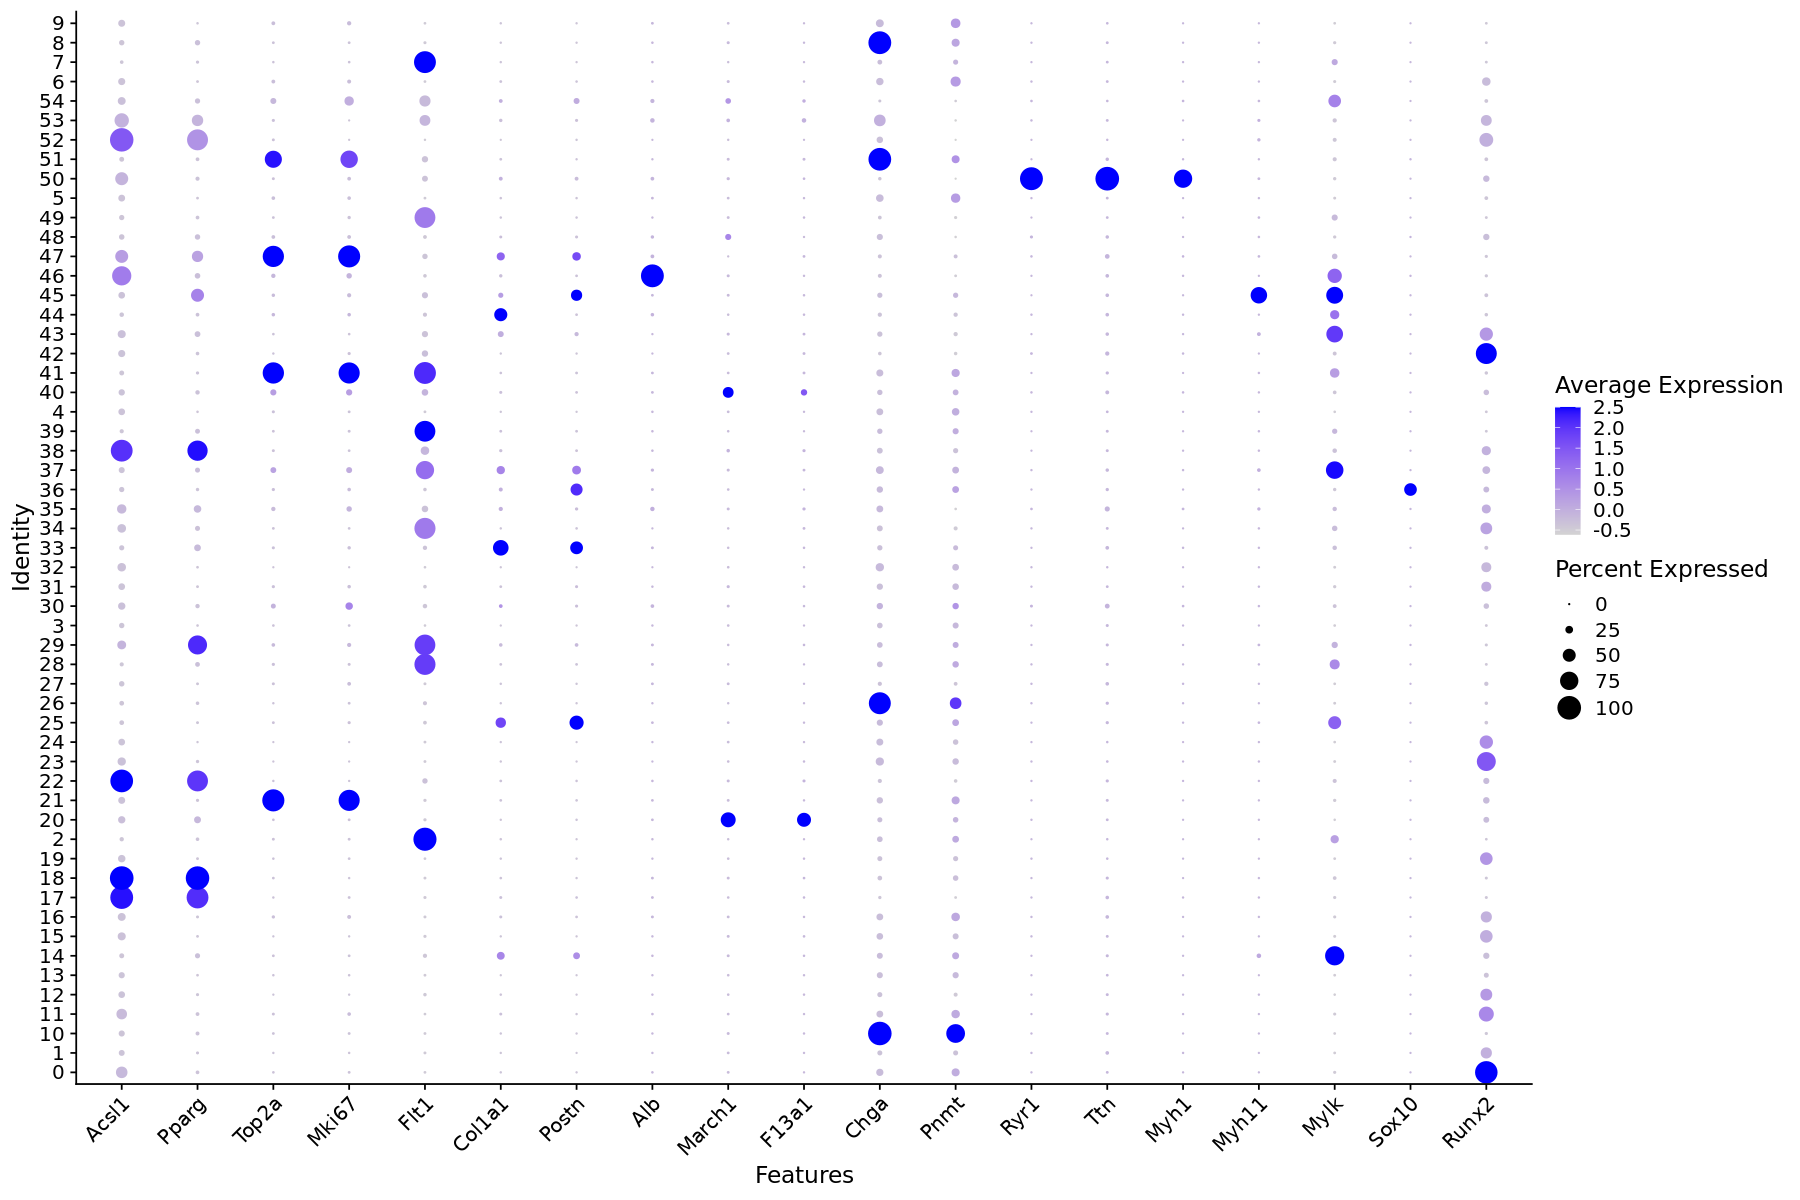

In [151]:
# https://panglaodb.se/markers.html
#pdf(file="plots/adrenal/annotation/marker_dotplot.pdf",
#    width = 20, height = 12)
DefaultAssay(combined.sct) = "SCT"
Idents(combined.sct) = "seurat_clusters"
Idents(combined.sct) = factor(Idents(combined.sct), levels = sort(as.character(unique(Idents(combined.sct)))))
DotPlot(combined.sct, features = genes)+ theme(axis.text.x = element_text(angle = 45, hjust = 1)) 
#dev.off()

### FeaturePlots of marker genes

In [146]:
png(file="plots/adrenal/annotation/marker_featureplots.png",
    width = 1200, height = 1200)
DefaultAssay(combined.sct) = "SCT"
Idents(combined.sct) = "seurat_clusters"
Idents(combined.sct) = factor(Idents(combined.sct), levels = sort(as.character(unique(Idents(combined.sct)))))

FeaturePlot(combined.sct, pt.size = 0.1,
            features = genes, ncol =6)  & scale_colour_gradientn(colours = viridis(11)) & 
                        NoAxes()& 
                        theme(text = element_text(size = 18))

dev.off()


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will rep

png 
  2

## Manual subtypes annotation

In [6]:
combined.sct$subtypes = combined.sct$seurat_clusters
combined.sct$subtypes = gsub("\\<0\\>","X_zone",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<1\\>","Cortex_ZF",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<2\\>","Endothelial",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<3\\>","Cortex_ZG",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<4\\>","Cortex_ZG",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<5\\>","Cortex_ZF",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<6\\>","Cortex_ZF",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<7\\>","Endothelial",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<8\\>","Medulla_NE",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<9\\>","Cortex_ZG",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<10\\>","Medulla_EPI",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<11\\>","Cortex_ZF",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<12\\>","Y_zone",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<13\\>","Cortex_ZF",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<14\\>","Stromal",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<15\\>","Cortex_ZF",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<16\\>","Cortex_ZF",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<17\\>","Adipocytes",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<18\\>","Adipocytes",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<19\\>","Cortex_ZF",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<20\\>","Macrophages",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<21\\>","Cortex_cycling",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<22\\>","Adipocytes",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<23\\>","Y_zone",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<24\\>","Y_zone",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<25\\>","Fibroblast2",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<26\\>","Medulla_EPI",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<27\\>","Cortex_ZG",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<28\\>","Endothelial",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<29\\>","Endothelial",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<30\\>","Cortex_ZF",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<31\\>","Cortex_ZF",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<32\\>","Y_zone",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<33\\>","Fibroblast1",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<34\\>","Cortex_ZF",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<35\\>","Cortex_ZF",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<36\\>","Sox10+",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<37\\>","Stromal",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<38\\>","Adipocytes",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<39\\>","Endothelial",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<40\\>","Macrophages",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<41\\>","Endothelial_cycling",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<42\\>","Cortex_ZF",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<43\\>","Stromal",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<44\\>","Capsule",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<45\\>","Smooth_muscle",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<46\\>","Hepatocyte",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<47\\>","Fibroblast_cycling",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<48\\>","Medulla_early",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<49\\>","Cortex_ZG",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<50\\>","Skeletal_muscle",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<51\\>","Medulla_early",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<52\\>","Adipocytes",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<53\\>","Y_zone",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<54\\>","Stromal",combined.sct$subtypes)


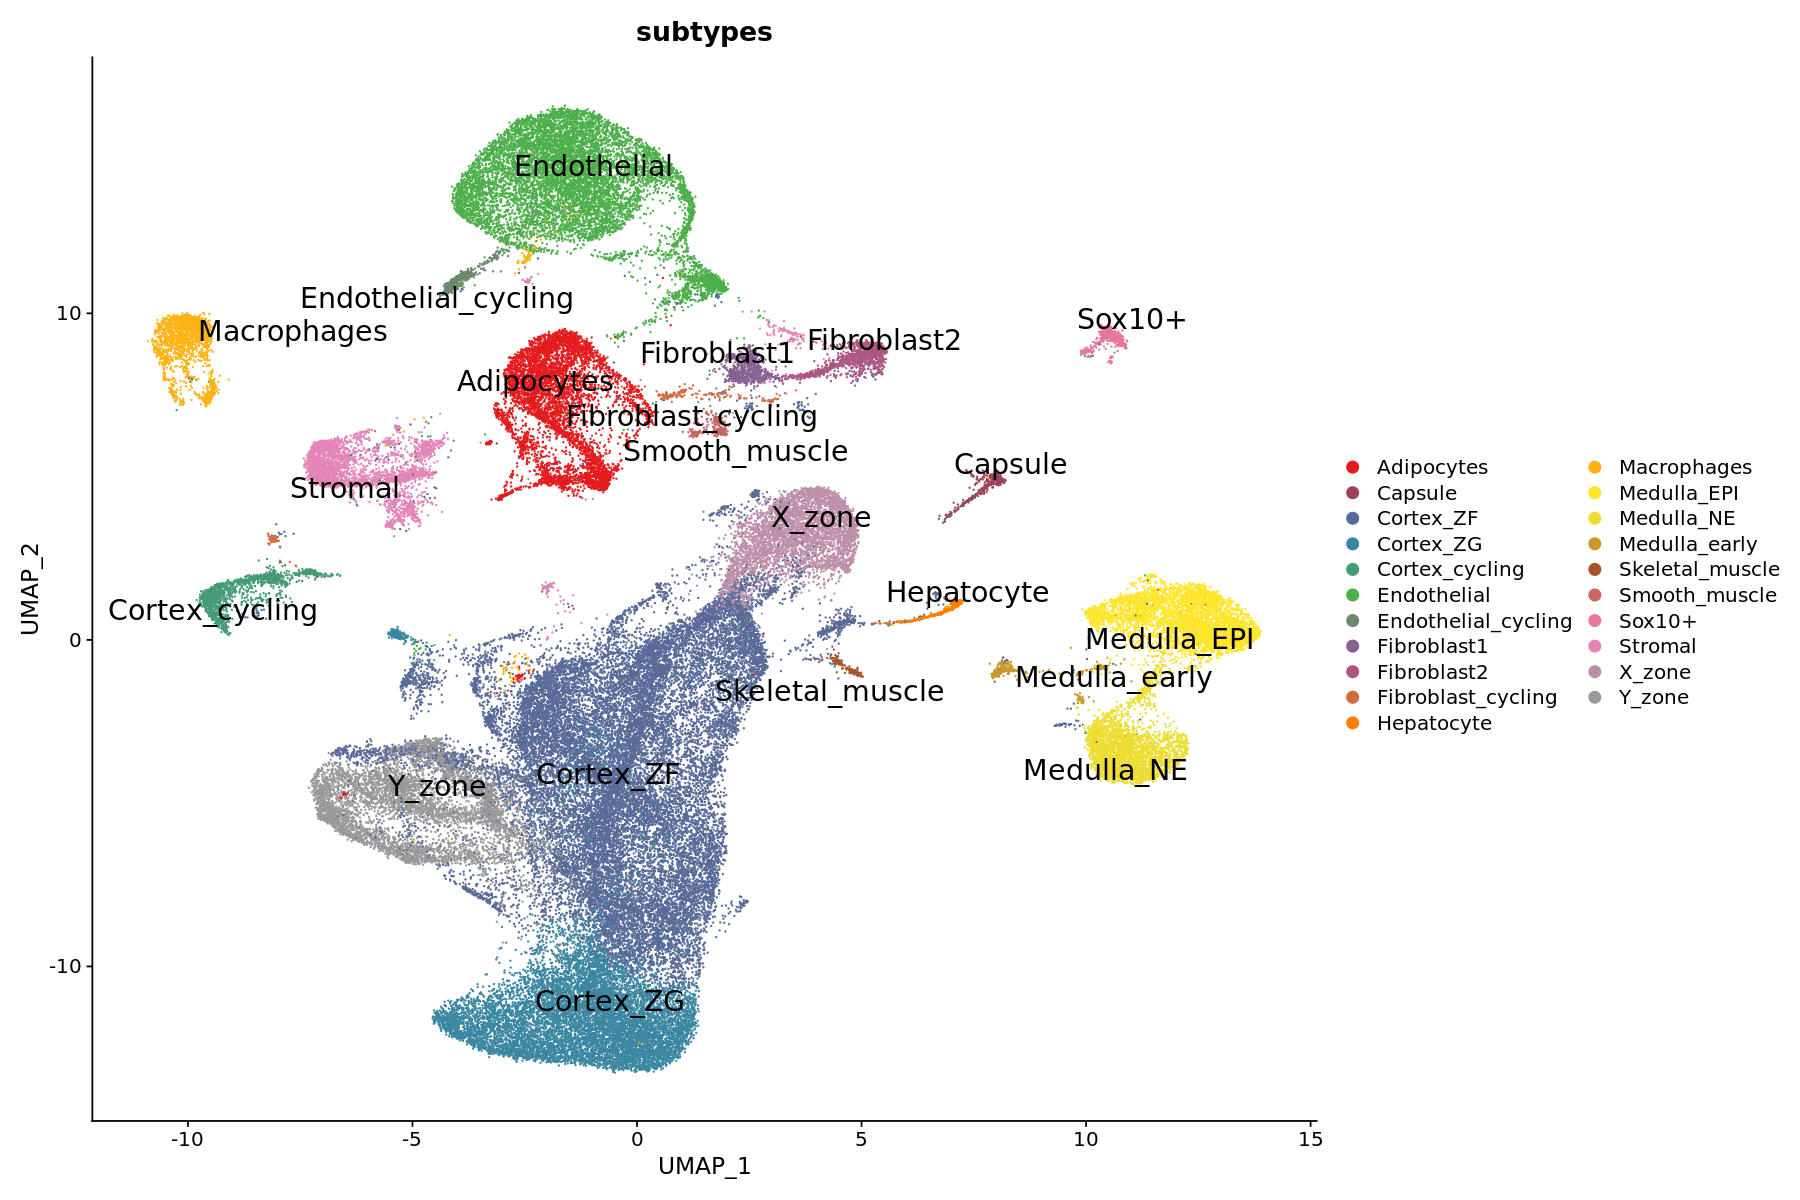

In [7]:
options(repr.plot.width=15, repr.plot.height=10)


nclusters = length(unique(combined.sct$subtypes))
cluster_cols = colorRampPalette(brewer.pal(9,"Set1"))(nclusters)

DimPlot(combined.sct, reduction = "umap", 
        group.by = "subtypes", label = TRUE, label.size = 6, repel = TRUE, 
        shuffle = T,cols = cluster_cols)


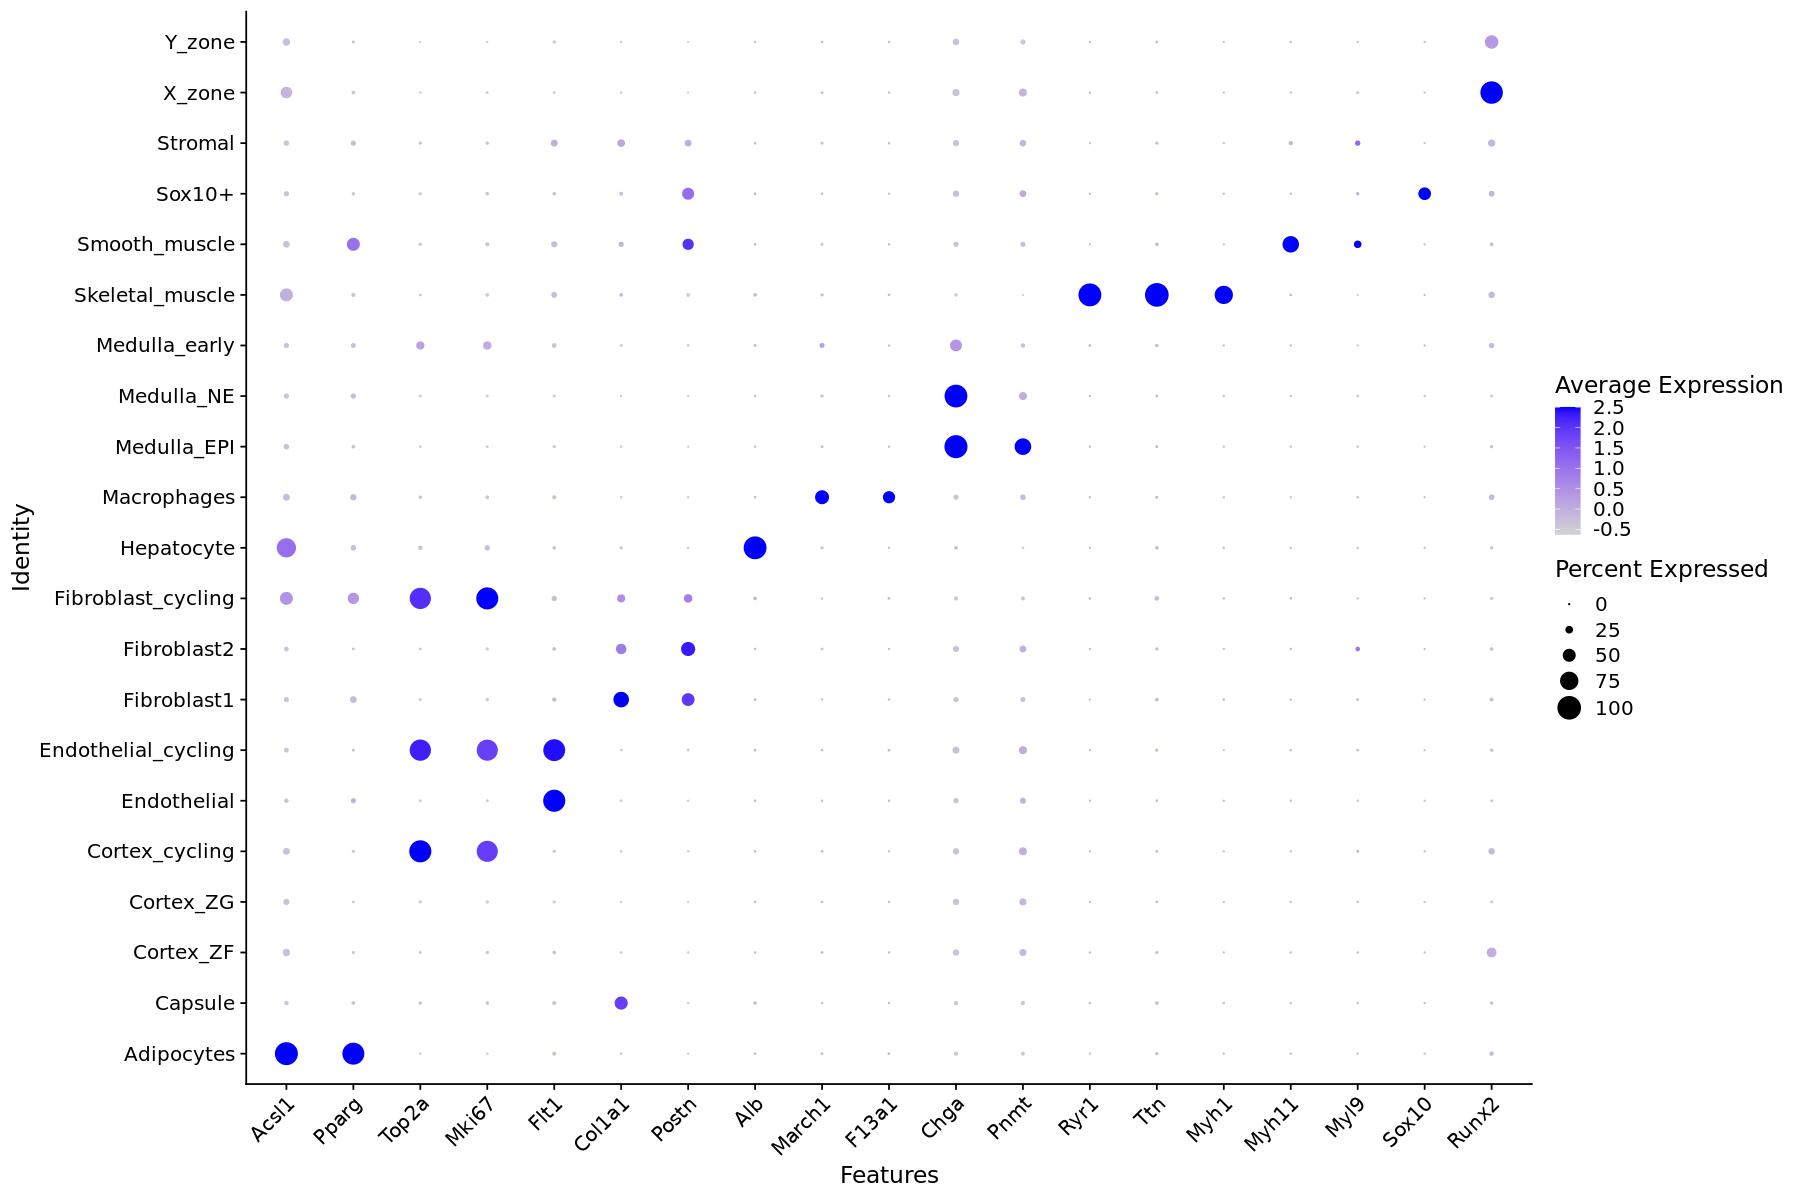

In [8]:
# https://panglaodb.se/markers.html
#pdf(file="plots/adrenal/annotation/marker_dotplot.pdf",
#    width = 20, height = 12)
DefaultAssay(combined.sct) = "SCT"
Idents(combined.sct) = "subtypes"
Idents(combined.sct) = factor(Idents(combined.sct), levels = sort(as.character(unique(Idents(combined.sct)))))
DotPlot(combined.sct, features = genes)+ theme(axis.text.x = element_text(angle = 45, hjust = 1)) 
#dev.off()

# Add celltypes and gen_celltypes metadata
Based on the subtypes annotation, we can group the cells into broader categories.

In [10]:
combined.sct$celltypes = combined.sct$subtypes

combined.sct$celltypes = gsub("\\<Cortex_ZG\\>","Cortex",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<Cortex_ZF\\>","Cortex",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<X_zone\\>","Cortex",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<Y_zone\\>","Cortex",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<Cortex_cycling\\>","Cortex",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<Medulla_early\\>","Medulla",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<Medulla_NE\\>","Medulla",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<Medulla_EPI\\>","Medulla",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<Endothelial_cycling\\>","Cycling",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<Fibroblast_cycling\\>","Cycling",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<Fibroblast1\\>","Fibroblast",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<Fibroblast2\\>","Fibroblast",combined.sct$celltypes)

table(combined.sct$celltypes )
combined.sct$gen_celltype = combined.sct$celltypes

combined.sct$gen_celltype = gsub("\\<Macrophages\\>","Myeloid",combined.sct$gen_celltype)
combined.sct$gen_celltype = gsub("\\<Skeletal_muscle\\>","Myonuclei",combined.sct$gen_celltype)



     Adipocytes         Capsule          Cortex         Cycling     Endothelial 
           5794             379           48896             720            9840 
     Fibroblast      Hepatocyte     Macrophages         Medulla Skeletal_muscle 
           2044             340            1959            7665             166 
  Smooth_muscle          Sox10+         Stromal 
            362             671            3376 

In [11]:
table(combined.sct$gen_celltype)



   Adipocytes       Capsule        Cortex       Cycling   Endothelial 
         5794           379         48896           720          9840 
   Fibroblast    Hepatocyte       Medulla       Myeloid     Myonuclei 
         2044           340          7665          1959           166 
Smooth_muscle        Sox10+       Stromal 
          362           671          3376 

# Plotting the 3 levels of annotations

In [18]:
color_ref = read.delim("ref/enc4_mouse_snrna_celltypes_c2c12.csv",sep=",",col.names = c("tissue","gen_celltype","celltypes",
                                                                              "subtypes","gen_celltype_color",
                                                                              "celltype_color","subtype_color"))
gen_celltype_colors = unique(color_ref[color_ref$tissue == "Adrenal",c("gen_celltype","gen_celltype_color")])
rownames(gen_celltype_colors) = gen_celltype_colors$gen_celltype
gen_celltype_colors = gen_celltype_colors[sort(unique(combined.sct$gen_celltype)),]

pdf(file="plots/adrenal/annotation/UMAP_final_gen_celltype.pdf",
    width = 15, height = 10)

DimPlot(combined.sct, reduction = "umap", 
        group.by = "gen_celltype", 
        label = TRUE, label.size = 8, repel = TRUE,
       cols = gen_celltype_colors$gen_celltype_color)

dev.off()

png 
  2

In [14]:
celltype_colors = unique(color_ref[color_ref$tissue == "Adrenal",c("celltypes","celltype_color")])
rownames(celltype_colors) = celltype_colors$celltypes
celltype_colors = celltype_colors[sort(unique(combined.sct$celltypes)),]

pdf(file="plots/adrenal/annotation/UMAP_final_celltypes.pdf",
    width = 15, height = 10)

DimPlot(combined.sct, reduction = "umap", 
        group.by = "celltypes", 
        label = TRUE, label.size = 8, repel = TRUE,
       cols = celltype_colors$celltype_color)

dev.off()

png 
  2

In [15]:
subtype_colors = unique(color_ref[color_ref$tissue == "Adrenal",c("subtypes","subtype_color")])
rownames(subtype_colors) = subtype_colors$subtypes
subtype_colors = subtype_colors[sort(unique(combined.sct$subtypes)),]

pdf(file="plots/adrenal/annotation/UMAP_final_subtypes.pdf",
    width = 15, height = 10)

DimPlot(combined.sct, reduction = "umap", 
        group.by = "subtypes", 
        label = TRUE, label.size = 8, repel = TRUE,
       cols = celltype_colors$subtype_color)

dev.off()

png 
  2

## Proportion plot of celltypes over timepoint

In [16]:
combined.sct_parse = subset(combined.sct,subset= technology == "Parse")

samples = sort(unique(combined.sct_parse$timepoint))
dflist = list()
for (i in 1:length(unique(combined.sct_parse$timepoint))){
  tp=combined.sct_parse@meta.data[combined.sct_parse@meta.data$timepoint == samples[i],]
  #tp=tp[complete.cases(tp),]
  tp_df=as.data.frame(table(tp$celltypes))
  tp_df$percentage=tp_df$Freq/nrow(tp)
  tp_df$timepoint=rep(i,nrow(tp_df))
  dflist[[i]]=tp_df
}
df = do.call(rbind, dflist)
df <- df[order(df$timepoint),]
colnames(df)= c("celltypes","Freq","percentage","timepoint")



In [17]:
pdf(file="plots/adrenal/annotation/timepoint_celltypes_proportions.pdf",
    width = 15, height = 10)

ggplot(df, aes(x=timepoint, y=percentage, fill=celltypes)) + 
  geom_area()  +
  scale_fill_manual(values= celltype_colors$celltype_color) + 
  scale_x_continuous(breaks = c(1,2,3,4,5,6,7),labels= c("PND_04","PND_10","PND_14",
                                                         "PND_25","PND_36","PNM_02","PNM_18-20"))+
  scale_y_continuous(breaks = c(0,0.1,0.2,0.3,0.4,0.5,
                                0.6,0.7,0.8,0.9,1.0),labels= c("0%","10%","20%","30%","40%","50%","60%","70%","80%","90%","100%")) + 
theme_minimal()+theme(text = element_text(size = 30)) + 
theme(axis.text.x = element_text(size = 30))  + 
theme(axis.text.y = element_text(size = 30))   + 
theme(axis.text.x = element_text(angle = 45, hjust = 1))
  
dev.off()

png 
  2

# Save

In [18]:
saveRDS(combined.sct,file="seurat/adrenal_Parse_10x_integrated.rds")


# Find celltype marker genes

In [ ]:
DefaultAssay(combined.sct)= "integrated"
Idents(combined.sct) = "gen_celltype"
markers <- FindAllMarkers(combined.sct, 
                             only.pos = TRUE, 
                             min.pct = 0.1, 
                             logfc.threshold = 0.25, 
                             verbose = F)

write.table(markers,file=paste0("seurat/markers/adrenal_gen_celltype_marker_genes_only.pos_min.pct0.1_logfc.threshold0.25.tsv"),
            sep="\t",
            quote=F,
            row.names = F)



In [ ]:
Idents(combined.sct) = "celltypes"
markers <- FindAllMarkers(combined.sct, 
                             only.pos = TRUE, 
                             min.pct = 0.1, 
                             logfc.threshold = 0.25, 
                             verbose = F)

write.table(markers,file=paste0("seurat/markers/adrenal_celltypes_marker_genes_only.pos_min.pct0.1_logfc.threshold0.25.tsv"),
            sep="\t",
            quote=F,
            row.names = F)



In [159]:
Idents(combined.sct) = "subtypes"
DefaultAssay(combined.sct)= "integrated"

markers <- FindAllMarkers(combined.sct, 
                             only.pos = TRUE, 
                             min.pct = 0.1, 
                             logfc.threshold = 0.25, 
                             verbose = F)

write.table(markers,file=paste0("seurat/markers/adrenal_subtypes_marker_genes_only.pos_min.pct0.1_logfc.threshold0.25.tsv"),
            sep="\t",
            quote=F,
            row.names = F)

